In [2]:
from nilearn import image

# Load power template coords

powerfile = '/home/anton/Documents/Tulane/Hackathon/power264/power264MNI.nii.gz'

powerimg = image.load_img(powerfile)

print(powerimg.shape)

(91, 109, 91)


In [4]:
import numpy as np

# Load ROI coordinates

import re

# Radius 5
pat = re.compile('.*Power(\d+)([^#]+)#(-?\d+,-?\d+,-?\d+).*')

def parseLine(pat, line):
    res = pat.search(line)
    if res:
        idx, bfn, mni = res.groups()
        mni = np.array([int(coord) for coord in mni.split(',')]+[1])
        return (idx,bfn,mni)
    return None

roifile = '/home/anton/Documents/Tulane/Hackathon/power264/power264CoorMNI.sclib'
rois = []

with open(roifile, 'r') as f:
    for line in f.readlines():
        p = parseLine(pat, line)
        rois.append(p)

rois = [p for p in rois if p is not None]
print(len(rois))

264


In [71]:
import pickle

def getRoiImage(img, powerimg, tp):
    vol = image.index_img(img, tp)
    vol_resamp = image.resample_to_img(vol, powerimg)
    vol_rois = image.math_img('(img1 > 0)*img2', img1=powerimg, img2=vol_resamp)
    return vol_rois
    
def extractSignal(volRoiImg, rois, invXfrom):
    signal = np.zeros(len(rois))

    for i,roi in enumerate(rois):
        x,y,z,_ = np.floor(invaff@roi[-1]).astype('int')
        signal[i] = np.sum(volRoiImg.get_fdata()[x-2:x+2,y-2:y+2,z-2:z+2])
        
    return signal

signalAllSubj = []

for i in range(41,78):
    num = f'00{i}' if i < 10 else f'0{i}'
    subdir = f'/home/anton/Documents/Tulane/Hackathon/ds004144-out/sub-{num}/func'
    imgname = f'sub-{num}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    img = None
    
    try:
        img = image.load_img(f'{subdir}/{imgname}')
    except:
        continue
    
    signal = np.zeros((264,img.shape[-1]))
    invaff = np.linalg.inv(powerimg.affine)

    for tp in range(img.shape[-1]):
        volImg = getRoiImage(img, powerimg, tp)
        signal[:,tp] = extractSignal(volImg, rois, invaff)
        if tp%100 == 0:
            print(f'Completed tp {tp}')
            
    outfile = f'/home/anton/Documents/Tulane/Hackathon/ImageNomeR/data/fmri-ts-rest/sub-{num}.pkl'
    with open(outfile, 'wb') as f:
        pickle.dump(signal, f)
            
    signalAllSubj.append(signal)
    print(f'Completed {i}')        

signalAllSubj = np.stack(signalAllSubj)
print(signalAllSubj.shape)
print('Done')

Completed tp 0
Completed tp 100
Completed tp 200
Completed 42
Completed tp 0
Completed tp 100
Completed tp 200
Completed 43
Completed tp 0
Completed tp 100
Completed tp 200
Completed 44
Completed tp 0
Completed tp 100
Completed tp 200
Completed 45
Completed tp 0
Completed tp 100
Completed tp 200
Completed 46
Completed tp 0
Completed tp 100
Completed tp 200
Completed 47
Completed tp 0
Completed tp 100
Completed tp 200
Completed 48
Completed tp 0
Completed tp 100
Completed tp 200
Completed 49
Completed tp 0
Completed tp 100
Completed tp 200
Completed 50
Completed tp 0
Completed tp 100
Completed tp 200
Completed 52
Completed tp 0
Completed tp 100
Completed tp 200
Completed 53
Completed tp 0
Completed tp 100
Completed tp 200
Completed 54
Completed tp 0
Completed tp 100
Completed tp 200
Completed 55
Completed tp 0
Completed tp 100
Completed tp 200
Completed 56
Completed tp 0
Completed tp 100
Completed tp 200
Completed 58
Completed tp 0
Completed tp 100
Completed tp 200
Completed 59
Complete

In [47]:
signalAllSubj = []

for i in range(9,11):
    num = f'00{i}' if i < 10 else f'0{i}'
    infile = f'/home/anton/Documents/Tulane/Hackathon/ImageNomeR/data/fmri-ts-rest/sub-{num}.pkl'
    with open(infile, 'rb') as f:
        signal = pickle.load(f)
        signalAllSubj.append(signal)
        
signalAllSubj = np.stack(signalAllSubj)
print(signalAllSubj.shape)

(2, 264, 300)


In [62]:
from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

filtSignal = butter_bandpass_filter(signalAllSubj, 
                                    np.array([10,3/4*img.shape[-1]]), 
                                    img.shape[-1]*(2.1))
print(filtSignal.shape)

(2, 264, 300)


In [63]:
pSubj = []

for i in range(filtSignal.shape[0]):
    p = np.corrcoef(filtSignal[i])
    pSubj.append(p)
    
pSubj = np.stack(pSubj)

print(pSubj.shape)

(2, 264, 264)


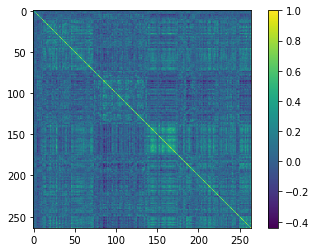

In [65]:
import matplotlib.pyplot as plt

plt.imshow(pSubj[1])
plt.colorbar()
plt.show()